# VQ-VAE

## Images

In [ ]:
!pip install dm-sonnet dm-tree

     |████████████████████████████████| 256kB 8.1MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree
import pandas as pd

try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.4.1
Sonnet version 2.0.0


# Download data
This requires a connection to the internet and will download ~160MB.


In [ ]:
cifar10 = tfds.as_numpy(tfds.load("cifar10:3.0.2", split="train+test", batch_size=-1))
cifar10.pop("id", None)
cifar10.pop("label")
tree.map_structure(lambda x: f'{x.dtype.name}{list(x.shape)}', cifar10)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete04FUE9/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete04FUE9/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


{'image': 'uint8[60000, 32, 32, 3]'}

# Load the data into Numpy
We compute the variance of the whole training set to normalise the Mean Squared Error below.


In [ ]:
train_data_dict = tree.map_structure(lambda x: x[:40000], cifar10)
valid_data_dict = tree.map_structure(lambda x: x[40000:50000], cifar10)
test_data_dict = tree.map_structure(lambda x: x[50000:], cifar10)

In [ ]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [-0.5, 0.5]"""
  images = data_dict['image']
  data_dict['image'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

train_data_variance = np.var(train_data_dict['image'] / 255.0)
print('train data variance: %s' % train_data_variance)

train data variance: 0.06327039811675479


AttributeError: ignored

# Encoder & Decoder Architecture


In [ ]:
class ResidualStack(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = snt.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = snt.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(tf.nn.relu(h))
      conv1_out = conv1(tf.nn.relu(conv3_out))
      h += conv1_out
    return tf.nn.relu(h)  # Resnet V1 style


class Encoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._enc_1 = snt.Conv2D(
        output_channels=self._num_hiddens // 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")
    self._enc_2 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")
    self._enc_3 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

  def __call__(self, x):
    h = tf.nn.relu(self._enc_1(x))
    h = tf.nn.relu(self._enc_2(h))
    h = tf.nn.relu(self._enc_3(h))
    return self._residual_stack(h)


class Decoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._dec_1 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="dec_1")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    self._dec_2 = snt.Conv2DTranspose(
        output_channels=self._num_hiddens // 2,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")
    self._dec_3 = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")
    
  def __call__(self, x):
    h = self._dec_1(x)
    h = self._residual_stack(h)
    h = tf.nn.relu(self._dec_2(h))
    x_recon = self._dec_3(h)
    return x_recon
    

class VQVAEModel(snt.Module):
  def __init__(self, encoder, decoder, vqvae, pre_vq_conv1, 
               data_variance, name=None):
    super(VQVAEModel, self).__init__(name=name)
    self._encoder = encoder
    self._decoder = decoder
    self._vqvae = vqvae
    self._pre_vq_conv1 = pre_vq_conv1
    self._data_variance = data_variance

  def __call__(self, inputs, is_training):
    z = self._pre_vq_conv1(self._encoder(inputs))
    vq_output = self._vqvae(z, is_training=is_training)
    x_recon = self._decoder(vq_output['quantize'])
    recon_error = tf.reduce_mean((x_recon - inputs) ** 2) / self._data_variance
    loss = recon_error + vq_output['loss']
    return {
        'z': z,
        'x_recon': x_recon,
        'loss': loss,
        'recon_error': recon_error,
        'vq_output': vq_output,
    }

In [ ]:
class ResidualStack(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = snt.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = snt.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(tf.nn.relu(h))
      conv1_out = conv1(tf.nn.relu(conv3_out))
      h += conv1_out
    return tf.nn.relu(h)  # Resnet V1 style


# Build Model and train

In [ ]:
%%time

# Set hyper-parameters.
batch_size = 32
num_training_updates = 10000

num_hiddens = 32
num_residual_hiddens = 16
num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 8

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 256

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# # Data Loading.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)
  
model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(data):
  with tf.GradientTape() as tape:
    model_output = model(data['image'], is_training=True)
  trainable_variables = model.trainable_variables
  grads = tape.gradient(model_output['loss'], trainable_variables)
  optimizer.apply(grads, trainable_variables)

  return model_output

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []

for step_index, data in enumerate(train_dataset):
  train_results = train_step(data)
  train_losses.append(train_results['loss'])
  train_recon_errors.append(train_results['recon_error'])
  train_perplexities.append(train_results['vq_output']['perplexity'])
  train_vqvae_loss.append(train_results['vq_output']['loss'])

  if (step_index + 1) % 100 == 0:
    print('%d train loss: %f ' % (step_index + 1,
                                   np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))
  if step_index == num_training_updates:
    break

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f3e40132c20>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f3e40132c20>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f3e40132c20>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100 train loss: 0.539818 recon_error: 0.497 perplexity: 8.241 vqvae loss: 0.043
200 train loss: 0.272492 recon_error: 0.247 perplexity: 15.694 vqvae loss: 0.026
300 train loss: 0.222014 recon_error: 0.197 perplexity: 20.059 vqvae loss: 0.025
400 train loss: 0.204311 recon_error: 0.180 perplexity: 23.821 vqvae loss: 0.024
500 train

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

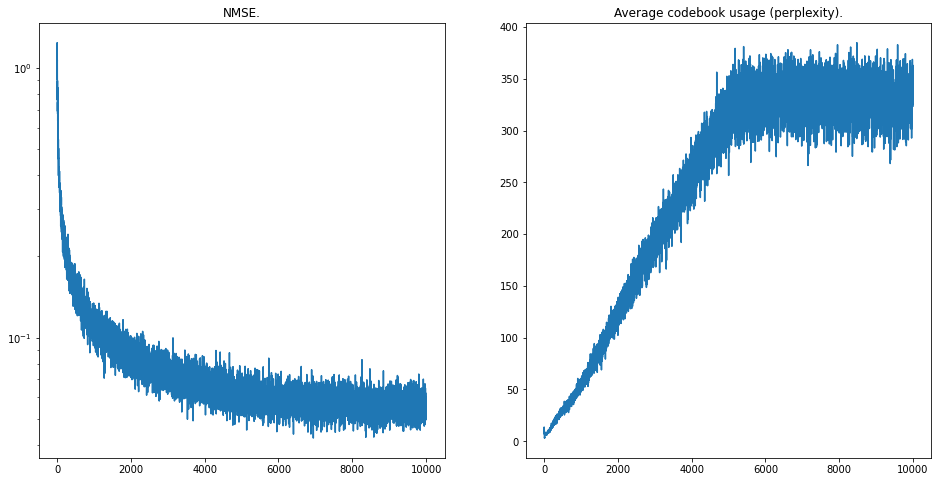

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_errors)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_perplexities)
ax.set_title('Average codebook usage (perplexity).')


# View reconstructions

(-0.5, 255.5, 127.5, -0.5)

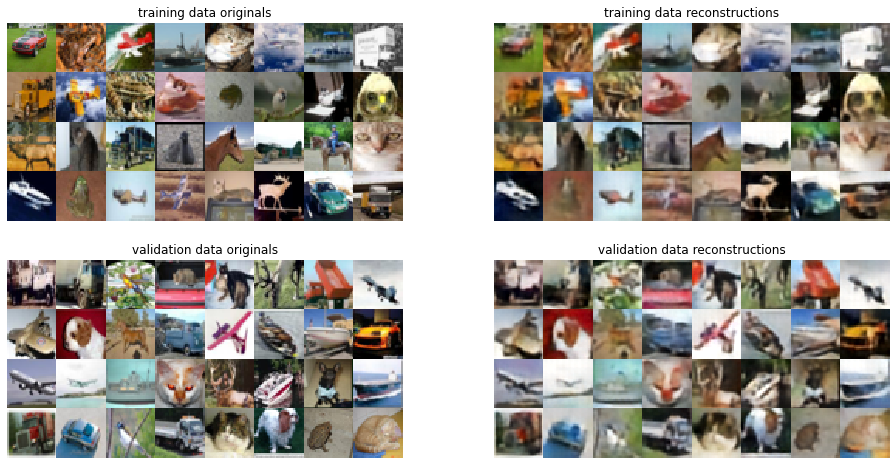

In [ ]:
# Reconstructions
train_batch = next(iter(train_dataset))
valid_batch = next(iter(valid_dataset))

# Put data through the model with is_training=False, so that in the case of 
# using EMA the codebook is not updated.
train_reconstructions = model(train_batch['image'],
                              is_training=False)['x_recon'].numpy()
valid_reconstructions = model(valid_batch['image'],
                              is_training=False)['x_recon'].numpy()


def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 32, 8 * 32, 3))
  return reshaped + 0.5



f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_batch['image'].numpy()),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_batch['image'].numpy()),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')

# Time Series

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [ ]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


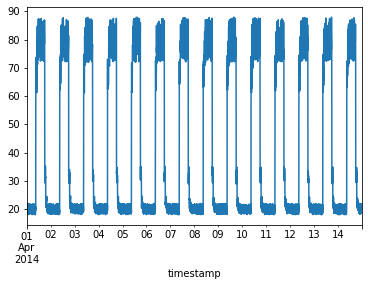

In [ ]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

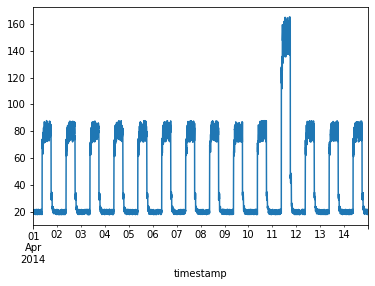

In [ ]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


In [ ]:
model = tf.keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0202 - val_loss: 0.0267
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0196 - val_loss: 0.0263
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0191 - val_loss: 0.0290
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0186 - val_loss: 0.0293
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.0264
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0177 - val_loss: 0.0258
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0267
Epoch 8/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0168 - val_loss: 0.0265
Epoch 9/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.0253
Epoch 10/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0161 - val_loss: 0.0243
Epoch 11/

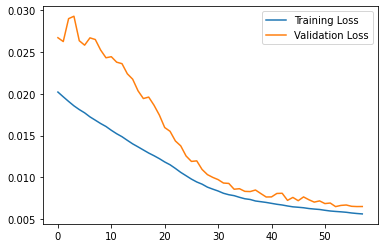

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

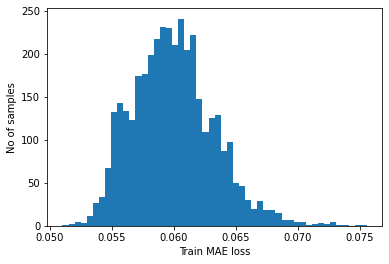

Reconstruction error threshold:  0.07555503901640155


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

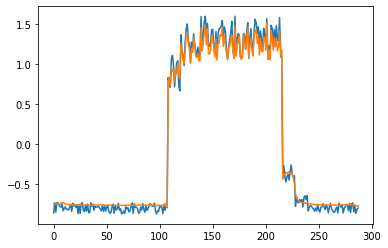

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Model

In [ ]:
encoder_input = keras.Input(shape=(x_train.shape[1], x_train.shape[2]), name="time series")
x = layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(encoder_input)
x = layers.Dropout(rate=0.2)(x)
encoder_output = layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()


x = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(encoder_output)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
decoder_output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time series (InputLayer)     [(None, 288, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
Total params: 3,856
Trainable params: 3,856
Non-trainable params: 0
_________________________________________________________________
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time series (InputLayer)     [(None, 288, 1)]          0         
____________________________________

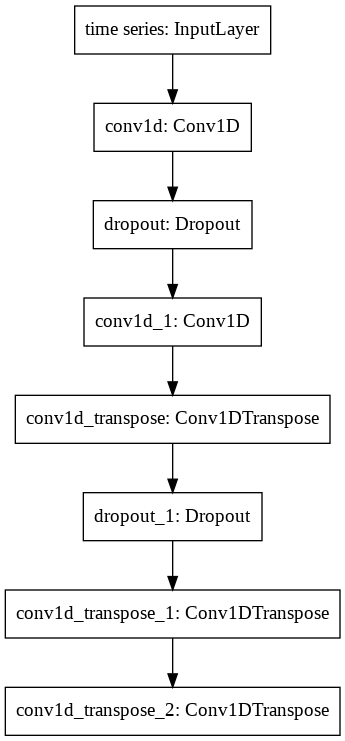

In [ ]:
tf.keras.utils.plot_model(autoencoder, expand_nested=True)

In [ ]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [ ]:
history = autoencoder.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/100
27/27 [==============================] - 31s 16ms/step - loss: 0.7672 - val_loss: 0.0738
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 0.1084 - val_loss: 0.0455
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0659 - val_loss: 0.0350
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0518 - val_loss: 0.0298
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0435 - val_loss: 0.0263
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0384 - val_loss: 0.0251
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0342 - val_loss: 0.0244
Epoch 8/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0308 - val_loss: 0.0230
Epoch 9/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0283 - val_loss: 0.0251
Epoch 10/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0264 - val_loss: 0.0249
Epoch 1

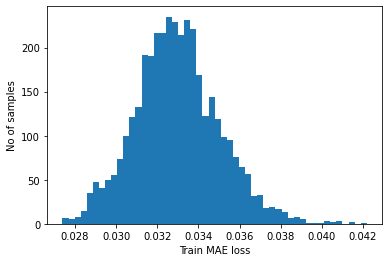

Reconstruction error threshold:  0.0421820394023422


In [ ]:
# Get train MAE loss.
x_train_pred = autoencoder.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

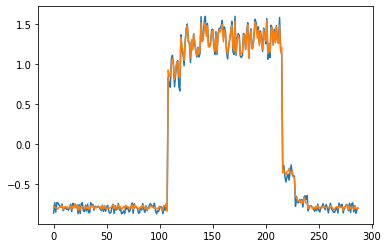

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

## New decoders

In [ ]:
class ResidualStack(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = snt.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = snt.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(tf.nn.relu(h))
      conv1_out = conv1(tf.nn.relu(conv3_out))
      h += conv1_out
    return tf.nn.relu(h)  # Resnet V1 style


In [ ]:
#encoder
encoder_input = keras.Input(shape=(x_train.shape[1], x_train.shape[2]), name="time series")
x = layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(encoder_input)
x = layers.Dropout(rate=0.2)(x)
encoder_output = layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

#normal decoder
x = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(encoder_output)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
decoder_output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same", name="reconstruction")(x)

#average decoder
y = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(encoder_output)
y = layers.Dropout(rate=0.2)(y)
y = layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(y)
decoder_average_output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same", name="average")(y)

#variance decoder

z = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(encoder_output)
z = layers.Dropout(rate=0.2)(z)
z = layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(z)
decoder_variance_output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same", name="variance")(z)

autoencoder_full = keras.Model(inputs = encoder_input, outputs = [decoder_output, decoder_average_output, decoder_variance_output], name="autoencoder_full")
autoencoder_full.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time series (InputLayer)     [(None, 288, 1)]          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 144, 32)           256       
_________________________________________________________________
dropout_25 (Dropout)         (None, 144, 32)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 72, 16)            3600      
Total params: 3,856
Trainable params: 3,856
Non-trainable params: 0
_________________________________________________________________
Model: "autoencoder_full"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time series (InputLayer)       

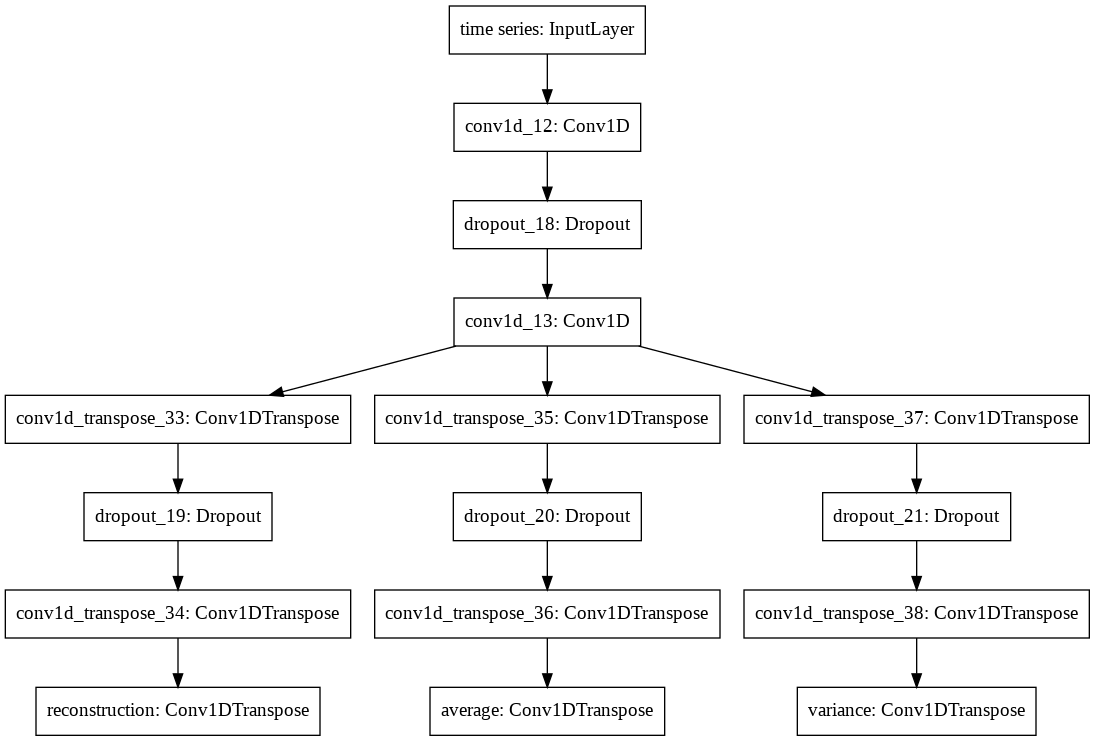

In [ ]:
tf.keras.utils.plot_model(autoencoder_full, expand_nested=True)

In [ ]:
def average_loss(x_input, x_average_estimate):
    x_average = tf.math.reduce_mean(x_input)
    squared_difference = tf.square(x_average - x_average_estimate)
    return tf.reduce_mean(squared_difference, axis=-1)

def variance_loss(x_input, x_variance_estimate):
    x_variance = tf.math.reduce_std(x_input)
    squared_difference = tf.square(x_variance - x_variance_estimate)
    return tf.reduce_mean(squared_difference, axis=-1)

In [ ]:
losses = {
	"reconstruction": "mse",
	"average": "average_loss",
  "variance": "variance_loss"
}
lossWeights = {"reconstruction": 1.0, "average": 0.5, "variance": 0.5}

In [ ]:
autoencoder_full.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=losses, loss_weights=lossWeights)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for x, y in dataset:
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(x)
        # Loss value for this batch.
        loss_values = [mse(), average_loss(), variance_loss()]
        # Add extra loss terms to the loss value.
        #loss_value += sum(model.losses)

    # Update the weights of the model to minimize the loss value.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

In [ ]:
history = autoencoder_full.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

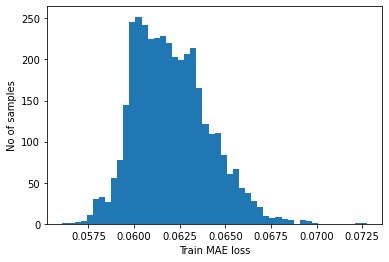

Reconstruction error threshold:  0.07275397382927141


In [ ]:
# Get train MAE loss.
x_train_pred = autoencoder_full.predict(x_train)[0]
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

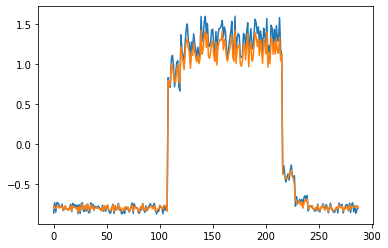

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

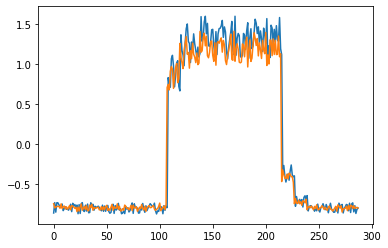

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[1])
plt.show()

In [ ]:
#average decoder
decoder_input = keras.Input(shape=(x_train.shape[1], x_train.shape[2]), name="latent space")
y = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(decoder_input)
y = layers.Dropout(rate=0.2)(y)
y = layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(y)
decoder_average_output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same", name="average")(y)

average_decoder = keras.Model(decoder_input, decoder_average_output, name="average_encoder")
average_decoder.summary()

Model: "average_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent space (InputLayer)    [(None, 288, 1)]          0         
_________________________________________________________________
conv1d_transpose_55 (Conv1DT (None, 576, 16)           128       
_________________________________________________________________
dropout_31 (Dropout)         (None, 576, 16)           0         
_________________________________________________________________
conv1d_transpose_56 (Conv1DT (None, 1152, 32)          3616      
_________________________________________________________________
average (Conv1DTranspose)    (None, 1152, 1)           225       
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


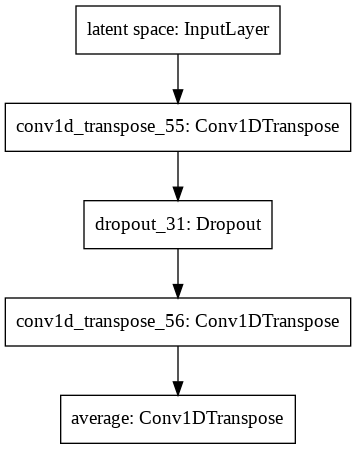

In [ ]:
tf.keras.utils.plot_model(average_decoder, expand_nested=True)

In [ ]:
#variance decoder
decoder_input = keras.Input(shape=(x_train.shape[1], x_train.shape[2]), name="latent space")
z = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(decoder_input)
z = layers.Dropout(rate=0.2)(z)
z = layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(z)
decoder_variance_output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same", name="variance")(z)

variance_decoder = keras.Model(decoder_input, decoder_variance_output, name="average_encoder")
variance_decoder.summary()

Model: "average_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent space (InputLayer)    [(None, 288, 1)]          0         
_________________________________________________________________
conv1d_transpose_59 (Conv1DT (None, 576, 16)           128       
_________________________________________________________________
dropout_33 (Dropout)         (None, 576, 16)           0         
_________________________________________________________________
conv1d_transpose_60 (Conv1DT (None, 1152, 32)          3616      
_________________________________________________________________
variance (Conv1DTranspose)   (None, 1152, 1)           225       
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


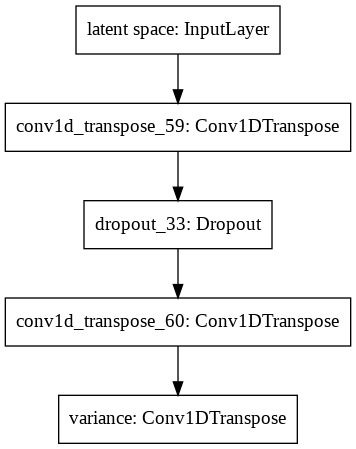

In [ ]:
tf.keras.utils.plot_model(variance_decoder, expand_nested=True)

In [ ]:
class ResidualStack(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = snt.Conv1D(
          output_channels=num_residual_hiddens,
          kernel_shape=2,
          stride=1,
          name="res1_%d" % i)
      conv1 = snt.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=1,
          stride=1,
          name="res2_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(tf.nn.relu(h))
      conv1_out = conv1(tf.nn.relu(conv3_out))
      h += conv1_out
    return tf.nn.relu(h)  # Resnet V1 style

In [ ]:
class Encoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._enc_1 = snt.Conv1D(
        output_channels = num_hiddens,
        kernel_shape = 7,
        padding = 'SAME',
        stride=2,
        name="enc_1")
    self._enc_2 = snt.Dropout(
        rate = 0.2, 
        name = 'enc_3')
    self._enc_3 = snt.Conv1D(
        output_channels = num_hiddens // 2,
        kernel_shape = 7,
        padding = 'SAME',
        stride=2,
        name="enc_2")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

  def __call__(self, x):
    h = tf.nn.relu(self._enc_1(x))
    h = tf.nn.relu(self._enc_2(h))
    h = tf.nn.relu(self._enc_3(h))
    return self._residual_stack(h)

In [ ]:
class Decoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._pre_vq = snt.Conv1D(
        output_channels=self._num_hiddens//2,
        kernel_shape=3,
        stride=1,
        padding = 'SAME',
        name="pre_vw")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    self._dec_1 = snt.Conv1DTranspose(
        output_channels=self._num_hiddens // 2,
        kernel_shape=7,
        stride=2,
        padding = 'SAME',
        name="dec_2")
    self._dec_2 = snt.Conv1DTranspose(
        output_channels=self._num_hiddens,
        kernel_shape=7,
        stride=2,
        padding = 'SAME',
        name="dec_2")
    self._dec_3 = snt.Conv1DTranspose(
        output_channels=1,
        kernel_shape=7,
        stride=2,
        padding = 'SAME',
        name="dec_3")
    
  def __call__(self, x):
    h = self._pre_vq(x)
    h = self._residual_stack(h)
    h = tf.nn.relu(self._dec_1(h))
    h = tf.nn.relu(self._dec_2(h))
    x_recon = self._dec_3(h)
    return x_recon

In [ ]:
class VQVAEModel(snt.Module):
  def __init__(self, encoder, decoder, vqvae, pre_vq_conv1, 
               data_variance, name=None):
    super(VQVAEModel, self).__init__(name=name)
    self._encoder = encoder
    self._decoder = decoder
    self._vqvae = vqvae
    self._pre_vq_conv1 = pre_vq_conv1
    self._data_variance = data_variance

  def __call__(self, inputs, is_training):
    z = self._pre_vq_conv1(self._encoder(inputs))
    vq_output = self._vqvae(z, is_training=is_training)
    x_recon = self._decoder(vq_output['quantize'])
    recon_error = tf.reduce_mean((x_recon - inputs) ** 2) / self._data_variance
    loss = recon_error + vq_output['loss']
    return {
        'z': z,
        'x_recon': x_recon,
        'loss': loss,
        'recon_error': recon_error,
        'vq_output': vq_output,
    }

In [ ]:
# Set hyper-parameters.
batch_size = 32
image_size = 32
num_training_updates = 10000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=1,
    stride=1,
    name="to_vq")


In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [ ]:
train_data_variance = np.var(df_training_value)
print(train_data_variance)

value    0.999752
dtype: float64


In [ ]:
TIME_STEPS = 32

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

train_dataset = create_sequences(df_training_value.values)
print("Training input shape: ", train_dataset.shape)

Training input shape:  (4000, 32, 1)


In [ ]:
# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv1D(output_channels=embedding_dim,
    kernel_shape=1,
    stride=1,
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)
  
model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(data):
  with tf.GradientTape() as tape:
    model_output = model(data, is_training=True)
  trainable_variables = model.trainable_variables
  grads = tape.gradient(model_output['loss'], trainable_variables)
  optimizer.apply(grads, trainable_variables)

  return model_output

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []

for step_index, data in enumerate(train_dataset):
  train_results = train_step(data)
  train_losses.append(train_results['loss'])
  train_recon_errors.append(train_results['recon_error'])
  train_perplexities.append(train_results['vq_output']['perplexity'])
  train_vqvae_loss.append(train_results['vq_output']['loss'])

  if (step_index + 1) % 100 == 0:
    print('%d train loss: %f ' % (step_index + 1,
                                   np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))
  if step_index == num_training_updates:
    break

ValueError: ignored